## Регуляризация
#### Применить методы линейной регресии, lasso, lasso cv, ridge и ridge cv к данным и вывести MSE и коэффициенты

In [79]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [80]:
#Загрузка файла
#Данные представляют собой информацио о прокате велисипедов. Учитываются факторы:
#Даты, сезона, года, месяца, праздника, дня недели, рабочего/выходного, погоды, температуры, влажности, скорости ветра, 
#количество зарегистрированных и случайных (не зарегистрирванных) пользователей
#cnt - количество арендованных велосипедов
#исследуется зависимость cnt от вышезаданных факторов


In [81]:
df = pd.read_csv('day.csv', sep=',')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [82]:
df.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796
730,731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


In [83]:
#размер таблицы
df.shape

(731, 16)

In [84]:
#Визуализация данных


plt.rcParams['figure.figsize'] = (12,8)

<AxesSubplot:xlabel='season', ylabel='cnt'>

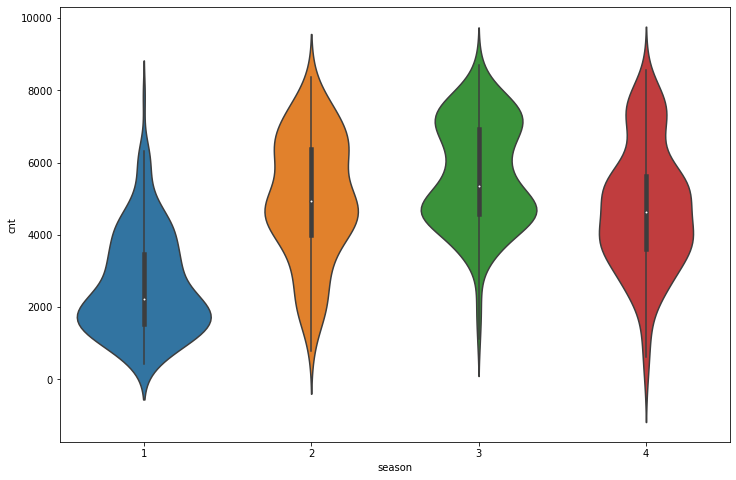

In [85]:
#зависимость количества арендованных велосипедов от сезона
#1 сезон - весна, 2 - лето, 3 - осень, 4 - зима
#весной в среднем арендовали 2000 велосипедов в день, летом - от 4000 до 8000, осенью примерно столько же, но чуть меньше, зимой -
#в среднем 4000
sns.violinplot(x=df['season'], y=df['cnt'])

<AxesSubplot:xlabel='season', ylabel='cnt'>

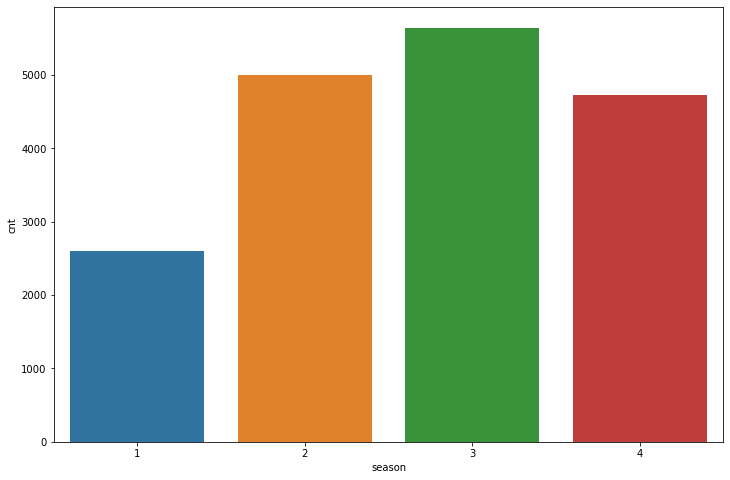

In [86]:
sns.barplot(x=df.groupby('season').mean().index, y=df.groupby('season').mean()['cnt'])

<AxesSubplot:>

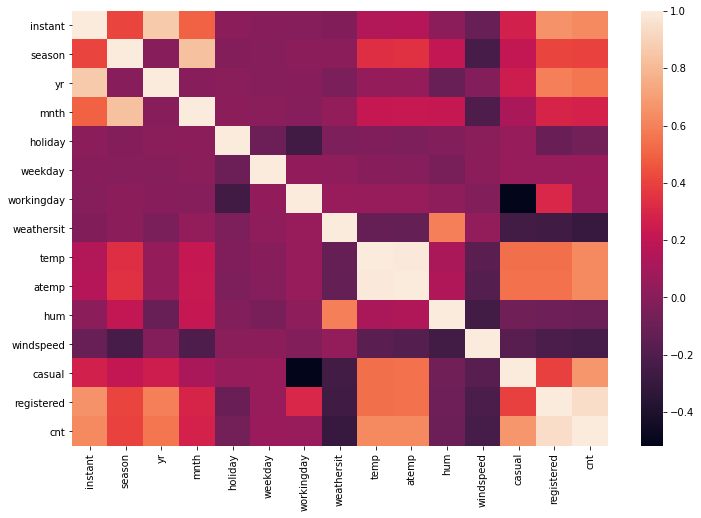

In [87]:
sns.heatmap(df.corr())


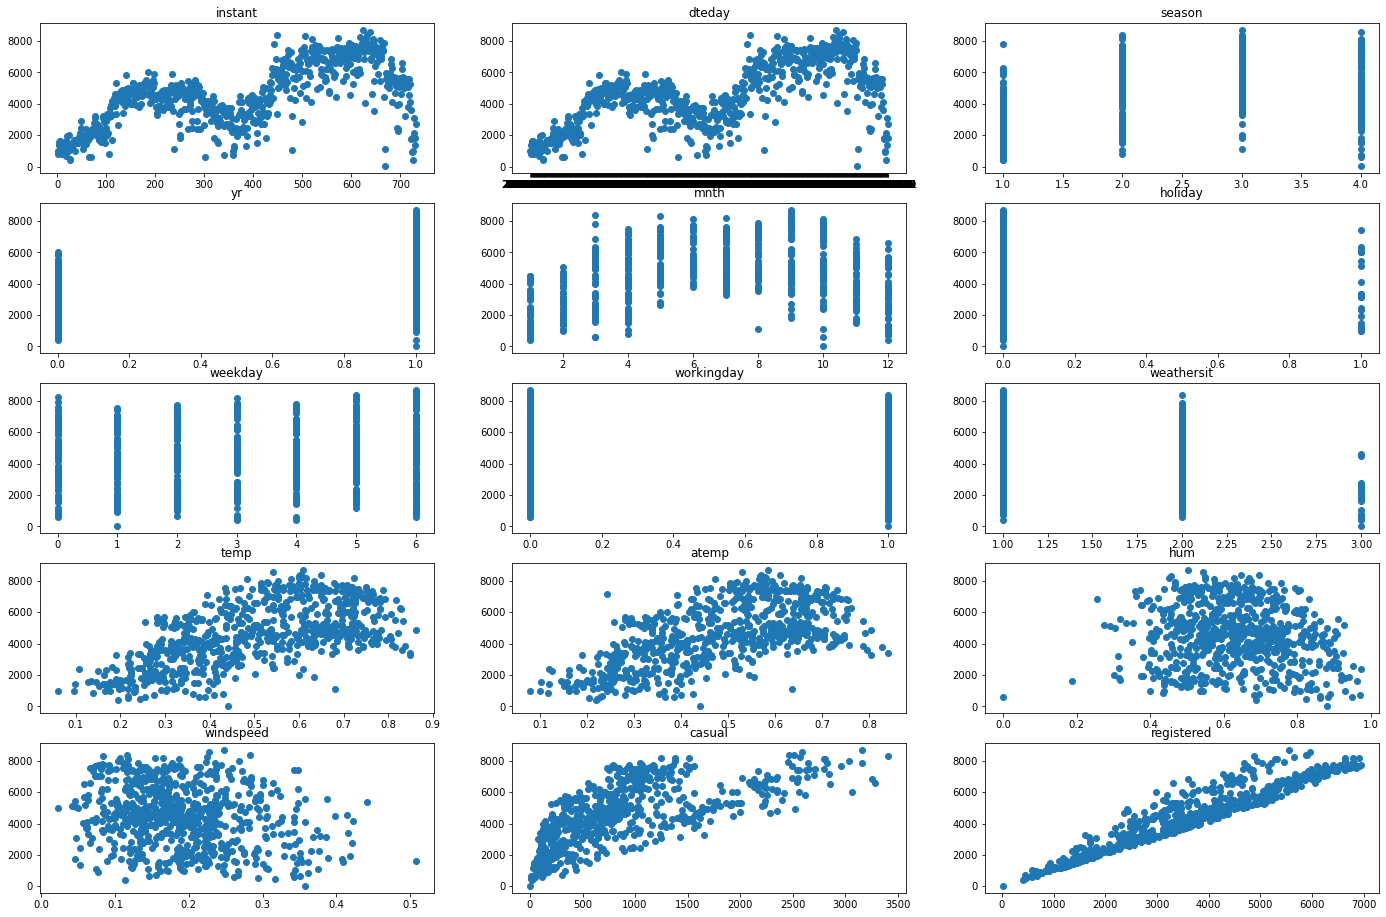

In [88]:
plt.rcParams['figure.figsize'] = (24,16)
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(5, 3, i+1)
    plt.scatter(df[col], df['cnt'])
    plt.title(col)

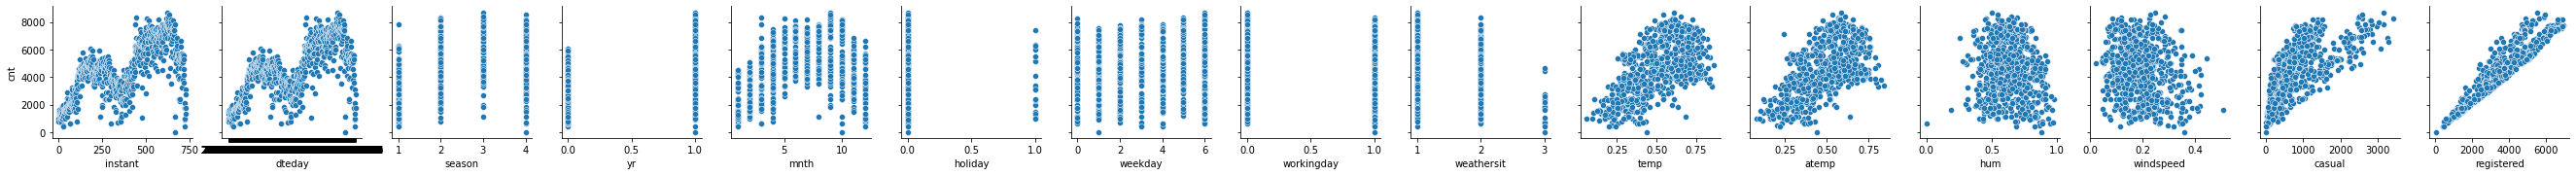

In [89]:
#Таблица рассеивания количества арендованных велосипедов от всех факторов
sns.pairplot(df, x_vars=df.columns.drop("cnt"), y_vars=["cnt"])

In [90]:
plt.rcParams['figure.figsize'] = (12,8)

<AxesSubplot:xlabel='mnth', ylabel='cnt'>

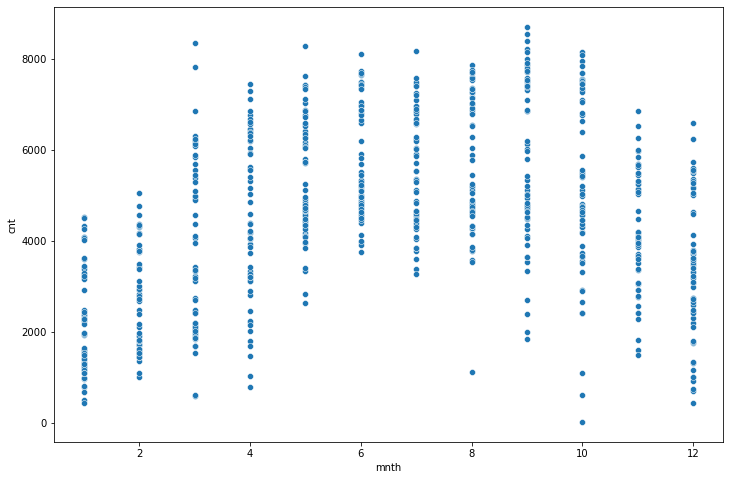

In [91]:
#отдельно рассмотрим таблицу рассеяния количества велосипедов от месяца. В среднем летом-осенью их больше всего арендуют
sns.scatterplot(x=df['mnth'],y=df['cnt'])

<AxesSubplot:xlabel='temp', ylabel='cnt'>

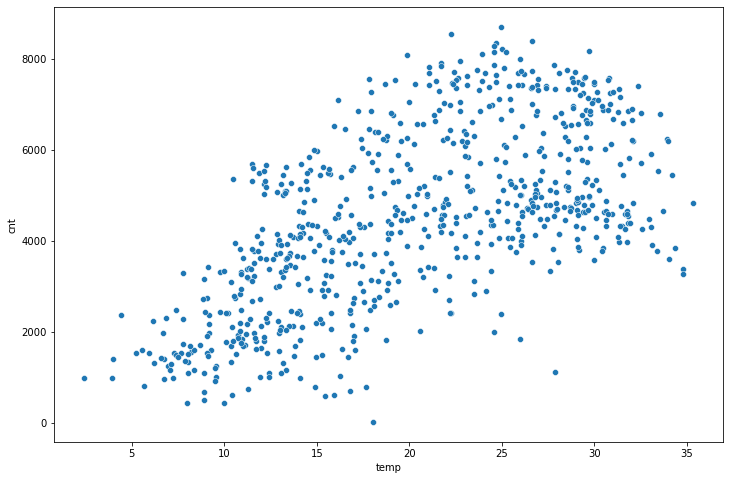

In [92]:
#Зависимость cnt от температуры воздуха (значения делятся на 41)
#вполне очевидно, что когда температура примерно 20-30 градусов (0.5-0.6), велосипеды арендуют более активнее
sns.scatterplot(x=df['temp']*41,y=df['cnt'])

<AxesSubplot:xlabel='weathersit', ylabel='cnt'>

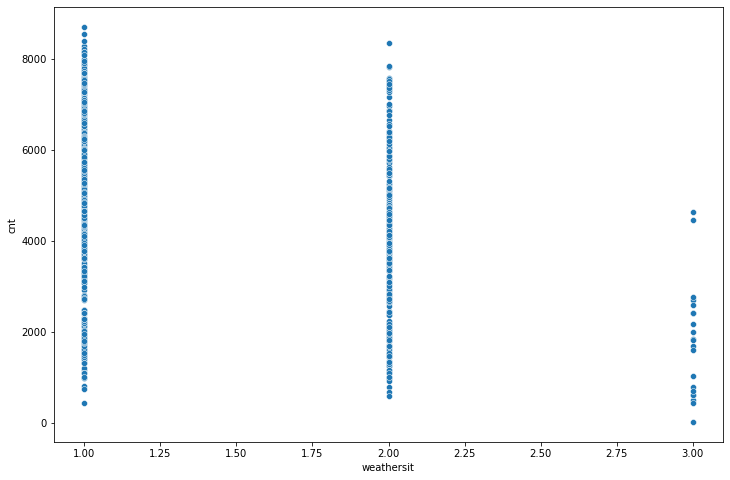

In [93]:
#Зависимость cnt от погоды
#1 - небольшая облачность
#2 - туман
#3 - легкий снег
#так же видна зависисмость что больше велосипедов арендуют в хорошую погоду. Когда идет снег, велосипеды арендуют достаточно редко
sns.scatterplot(x=df['weathersit'],y=df['cnt'])

In [94]:
#Замечание
#Визуалзация данных показывает, что некоторые столбцы в таблице не нужны. Однозначно можно убрать номер наблюдения,
#от него ничего не зависит. Дата наблюдения так же не нужна. В таблице уже есть столбцы и с днями недели и с месяцами и с годами
#Сначала исследуем зависимость cnt от всех факторов кроме этих двух, далее посмотрим, что ещё можно сделать для улучшения модели

In [95]:
df = df.drop(['instant', 'dteday'], axis=1)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [96]:
#Применить методы линейной регресии, lasso, lasso cv, ridge и ridge cv к данным и вывести MSE и коэффициенты
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [97]:
linreg = LinearRegression()
lasso = Lasso(random_state=42)
ridge = Ridge(random_state=42)
lasso_cv = LassoCV(random_state=42)
ridge_cv=RidgeCV()

In [98]:
#Объясняемая переменная - количество арендованных велосипедов
#Факторы - все параметры в таблице, исключая порядковый номер наблюдения и дату (у нас итак есть день, месяц, год)
y = df['cnt'].values
x = df.drop(['cnt'], axis=1).values

In [99]:
#Делим выборку на обучающую (70%) и контрольную (30%)
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.7)

In [100]:
#Стандартизация данных необходима, так как данные находятся в разных единицах измерения
#Лучше подходит стандартизация minmax, так как у нас много рваных данных, принимающих значения 0-1
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_valid)

In [101]:
#функция, которая применяет выбранный метод к данным и выводит корень MSE, коэффициенты для полученной модели и график,
#показывающий отклонения реальных значений от предсказанных по обущающей выборке
def train_validate_report(model, x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names):
    model.fit(x_train_scaled, y_train)
    R = model.score(x_train_scaled, y_train)
    print(f'Ошибка: {np.sqrt(mean_squared_error(y_valid, model.predict(x_valid_scaled)))}')
    print(f'Коэффициент детерминации: {R}')
    print(pd.DataFrame(model.coef_, feature_names, columns=['coef']).sort_values(by='coef', ascending=False))
    pred = pd.DataFrame({
        'pred':model.predict(x_valid_scaled),
        'real':y_valid})
    pred.plot()

Ошибка: 228.0477198941268
Коэффициент детерминации: 1.0
                    coef
registered  6.926000e+03
casual      3.408000e+03
windspeed   2.852105e-12
atemp       2.549464e-12
weathersit  1.492818e-12
mnth        5.491728e-13
holiday     3.235724e-13
weekday    -4.000120e-13
season     -7.166100e-13
hum        -1.126251e-12
yr         -1.146664e-12
workingday -2.132245e-12
temp       -2.893232e-12


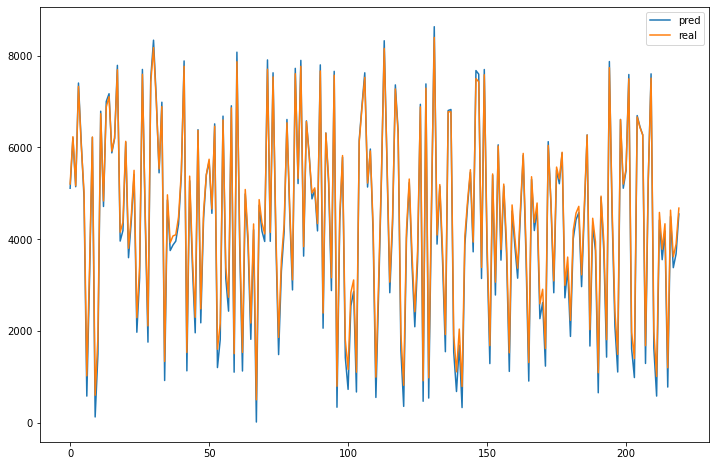

In [102]:
#Линейная регрессия
train_validate_report(linreg,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])


Ошибка: 222.85740102891938
Коэффициент детерминации: 0.9999909616247531
                   coef
registered  6908.319466
casual      3389.459183
yr             2.915474
season         0.000000
mnth           0.000000
holiday       -0.000000
weekday        0.000000
workingday    -0.000000
weathersit    -0.000000
temp           0.000000
atemp          0.000000
hum           -0.000000
windspeed     -0.000000


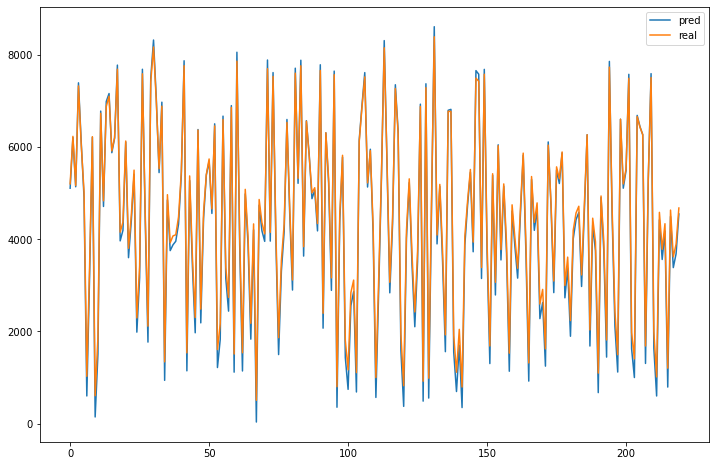

In [103]:
#Применим метод регуляризации Лассо
train_validate_report(lasso,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])

Ошибка: 225.11346763944238
Коэффициент детерминации: 0.9999971287422884
                   coef
registered  6916.052830
casual      3397.539982
yr             1.634797
season         0.000000
mnth           0.000000
holiday       -0.000000
weekday        0.000000
workingday    -0.000000
weathersit    -0.000000
temp           0.000000
atemp          0.000000
hum           -0.000000
windspeed     -0.000000


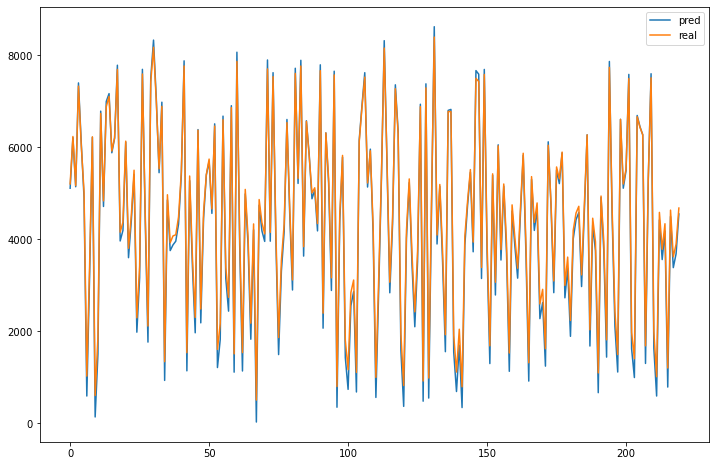

In [104]:
#Лассо CV
train_validate_report(lasso_cv,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])

Ошибка: 199.8816513431012
Коэффициент детерминации: 0.9962794164726116
                   coef
registered  5752.115910
casual      3218.117319
yr           316.569370
atemp        292.707620
temp         247.049761
season       228.357608
workingday   104.134063
weekday       39.139619
hum          -36.876753
mnth         -51.679667
holiday      -91.240283
windspeed   -148.662482
weathersit  -187.471082


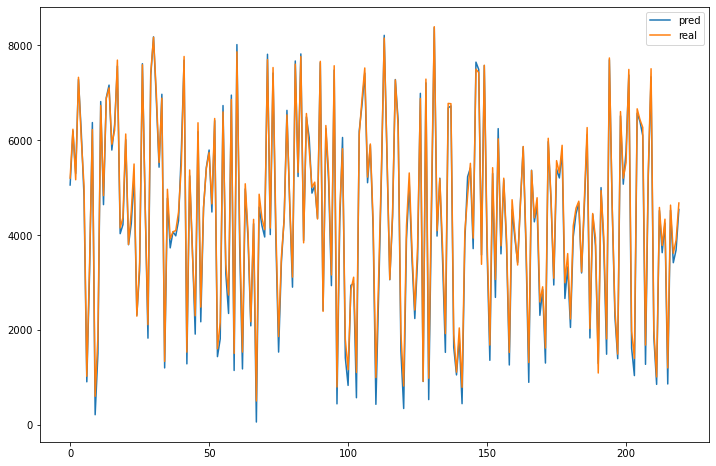

In [105]:
#Альфы для лассо CV
train_validate_report(ridge,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])

Ошибка: 199.8816513431012
Коэффициент детерминации: 0.9962794164726116
                   coef
registered  5752.115910
casual      3218.117319
yr           316.569370
atemp        292.707620
temp         247.049761
season       228.357608
workingday   104.134063
weekday       39.139619
hum          -36.876753
mnth         -51.679667
holiday      -91.240283
windspeed   -148.662482
weathersit  -187.471082


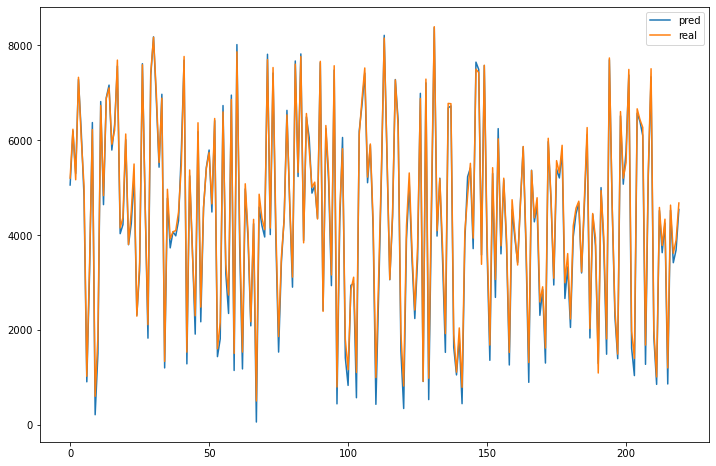

In [106]:
#Метод ridge
train_validate_report(ridge,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])

Ошибка: 219.79050972762292
Коэффициент детерминации: 0.9999439687161864
                   coef
registered  6778.501217
casual      3390.900754
atemp         45.456364
yr            39.429542
season        29.418258
temp          20.664055
workingday    14.827092
weekday        4.816613
hum           -4.631058
mnth          -7.493719
holiday      -11.707460
windspeed    -18.875250
weathersit   -23.439766


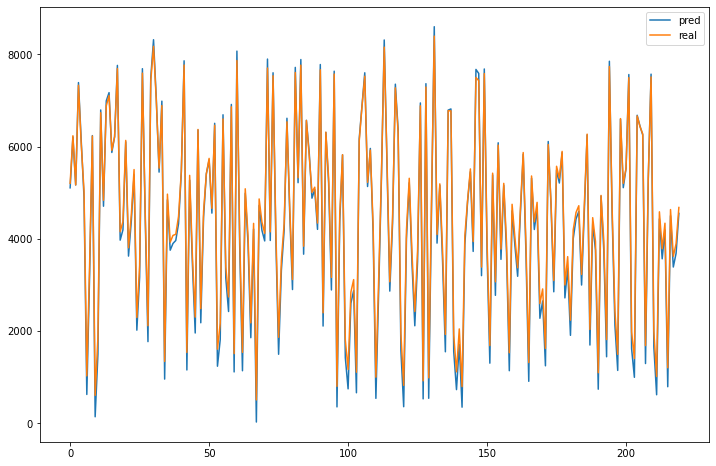

In [107]:
#Метод ridge cv
train_validate_report(ridge_cv,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])

## Придумать свой способ обучения модели (удаление незначащих данных, коррелирующих значений и тд)
### Сделать визуализацию и соответствующие выводы

<AxesSubplot:>

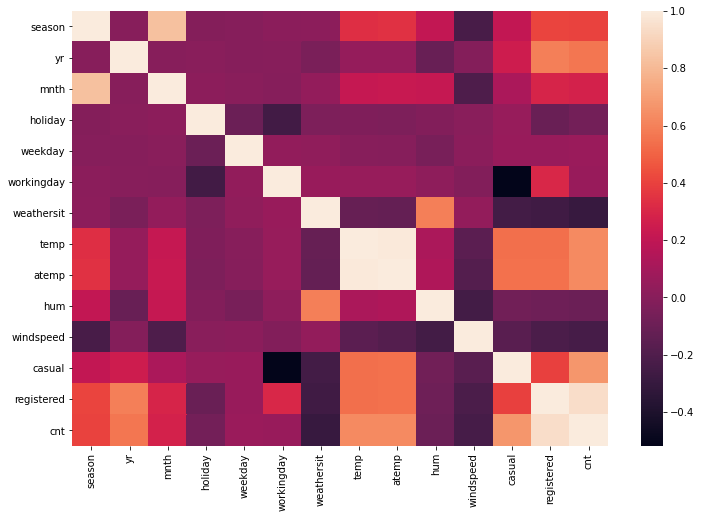

In [108]:
#Сделаем новую таблицу без weathersit (погода определяется детальнее через температуру, влажность, ветер),
#  atemp (температура тела сильно зависит от temp) и season (используем month)
sns.heatmap(df.corr())

In [109]:
#построим корреляционную матрицу и попробуем избавиться от незначащих переменных
df = df.drop(['weathersit', 'atemp', 'season'], axis=1)
df.head()

,yr,mnth,holiday,weekday,workingday,temp,hum,windspeed,casual,registered,cnt
0,0,1,0,6,0,0.344167,0.805833,0.160446,331,654,985
1,0,1,0,0,0,0.363478,0.696087,0.248539,131,670,801
2,0,1,0,1,1,0.196364,0.437273,0.248309,120,1229,1349
3,0,1,0,2,1,0.200000,0.590435,0.160296,108,1454,1562
4,0,1,0,3,1,0.226957,0.436957,0.186900,82,1518,1600


<AxesSubplot:>

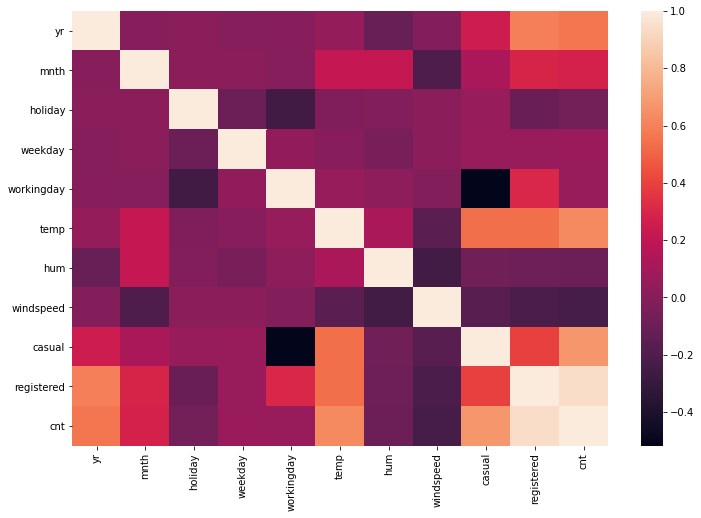

In [110]:
sns.heatmap(df.corr())

In [111]:
y = df['cnt'].values
x = df.drop(['cnt'], axis=1).values
x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.7)

In [112]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_valid)

Ошибка: 234.07655722550342
Коэффициент детерминации: 1.0
                    coef
registered  6.926000e+03
casual      3.408000e+03
workingday -1.996988e-13
weekday    -2.547744e-13
hum        -4.207124e-13
yr         -4.828124e-13
windspeed  -6.104439e-13
holiday    -6.322980e-13
mnth       -1.044005e-12
temp       -2.627470e-12


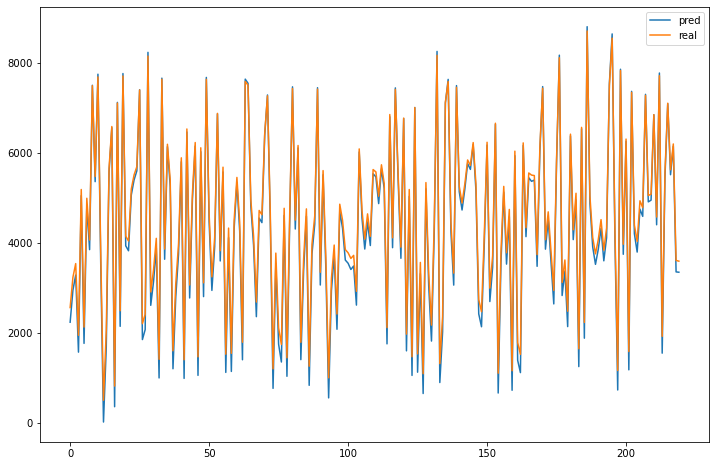

In [113]:
#Линейная регрессия
train_validate_report(linreg,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])

Ошибка: 230.64377062760448
Коэффициент детерминации: 0.9999915165597955
                   coef
registered  6911.118245
casual      3388.526347
yr             1.981036
mnth           0.000000
holiday       -0.000000
weekday        0.000000
workingday    -0.000000
temp           0.000000
hum           -0.000000
windspeed     -0.000000


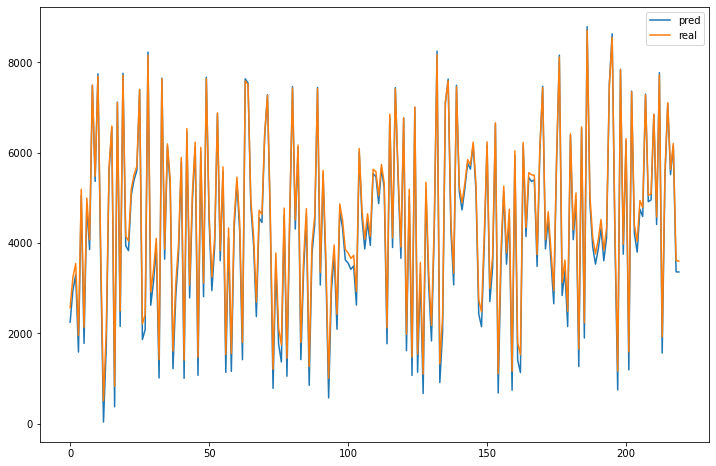

In [114]:
#Лассо
train_validate_report(lasso,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])

Ошибка: 232.1984340633787
Коэффициент детерминации: 0.9999975022859355
                   coef
registered  6917.870132
casual      3397.468842
yr             1.094919
mnth           0.000000
holiday       -0.000000
weekday        0.000000
workingday    -0.000000
temp           0.000000
hum           -0.000000
windspeed     -0.000000


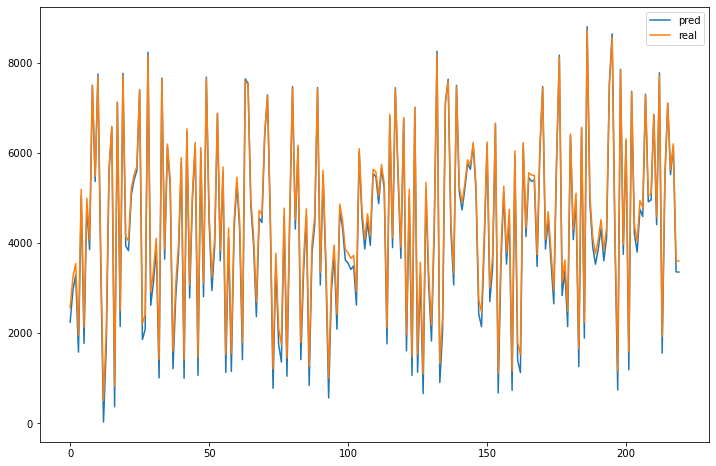

In [115]:
#Лассо CV
train_validate_report(lasso_cv,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])

Ошибка: 206.0656339000027
Коэффициент детерминации: 0.9973122321868128
                   coef
registered  6083.445058
casual      3271.204210
temp         430.041695
yr           218.860979
mnth         119.081328
workingday    87.678636
weekday       20.228044
holiday      -49.497779
windspeed   -175.289446
hum         -236.013075


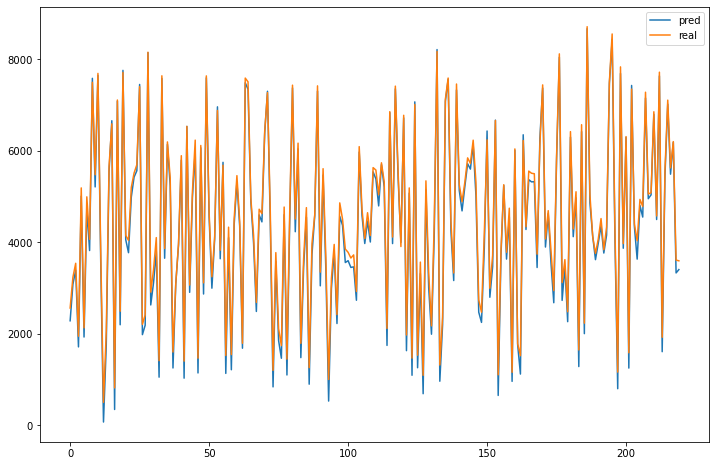

In [116]:
#Метод ridge
train_validate_report(ridge,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])

Ошибка: 228.73001760322563
Коэффициент детерминации: 0.9999624271645603
                   coef
registered  6824.580671
casual      3395.034664
temp          51.740410
yr            26.110717
mnth          14.541090
workingday    11.377292
weekday        2.337945
holiday       -6.024467
windspeed    -22.072095
hum          -30.705570


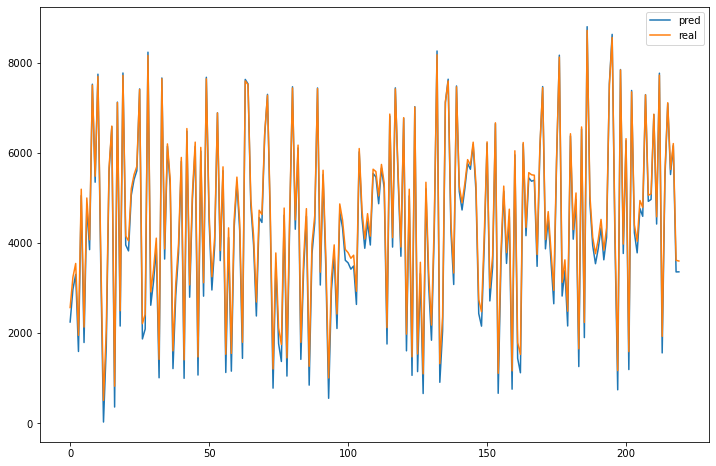

In [117]:
#Метод ridge cv
train_validate_report(ridge_cv,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])